use for gradient vectors: https://en.wikipedia.org/wiki/Gram%E2%80%93Schmidt_process

Prompt for altering the texts:
Consider the following task: I want to disentangle the semantics from the syntax in a text. Therefore, I want to change every semantically relevant word in the text that I am providing to you with a random other word that has the same part of speech tag and is not semantically closely related to the original word.

How to proceed:
- use groq ai to generate gibberisch
- take one original sentence and generate 20 gibberish sentences and average (both gradient avg -> cosine similarity and gradient -> cosine similarity avg)
- also do the substraction (avg gibberish - original)
- main idea: see if there is a difference and then go into the direction of the difference

In [1]:
import torch
import gc
from torch.utils.data import DataLoader
import pandas as pd
from peft import LoraConfig, get_peft_model
from transformers import AutoTokenizer, AutoModelForCausalLM, AdamW
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import json

In [2]:
# Load CSV Data
csv_path = "/home/tschuetz/shared/datasets/TFS_summary/original_gibberish.csv"
data = pd.read_csv(csv_path, sep=';', on_bad_lines='skip')
original_texts = data["original "].tolist()
gibberish_texts = data["gibberish"].tolist()

In [3]:
# Load JSON file with original and gibberish sentences
json_path = "/home/tschuetz/LLM-Cognitive-Sim/data/sentence_gibberish.json"
with open(json_path, "r") as f:
    json_data = json.load(f)

In [4]:
print(list(json_data.keys()))

['The cat sat on the mat.', 'She enjoys reading books in her free time.', 'He quickly ran across the busy street.']


In [5]:
# parameters

# model
#model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
model_name = "deepseek-ai/deepseek-llm-7b-base"

# LoRA config
r = 16
lora_alpha = 32
lora_dropout = 0.1
target_modules=["q_proj", "v_proj"]
bias="none"
task_type="CAUSAL_LM"

# LoRA training

""" output_dir="./lora_finetuned_model/deepseek-llm-7b-base" # path for saving the fine tuned model
per_device_train_batch_size=1 # batch size for each device (e.g. GPU)
gradient_accumulation_steps=16 # how many forward passes to accumulate before running a backward pass. simluates a larger batch size
learning_rate=2e-4 
num_train_epochs=3 # number of training epochs
save_strategy="epoch" # when the model is saved
fp16=True #this and the following command ensure better numerical stability
bf16=False
logging_steps=10 # after how many iterations each logging is reported
report_to="none"  # whether to log to external services like WandB """

' output_dir="./lora_finetuned_model/deepseek-llm-7b-base" # path for saving the fine tuned model\nper_device_train_batch_size=1 # batch size for each device (e.g. GPU)\ngradient_accumulation_steps=16 # how many forward passes to accumulate before running a backward pass. simluates a larger batch size\nlearning_rate=2e-4 \nnum_train_epochs=3 # number of training epochs\nsave_strategy="epoch" # when the model is saved\nfp16=True #this and the following command ensure better numerical stability\nbf16=False\nlogging_steps=10 # after how many iterations each logging is reported\nreport_to="none"  # whether to log to external services like WandB '

In [6]:
# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_name)
original_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_name)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
original_model.to(device)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(102400, 4096)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-06)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-06)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-06)
    (rotary_

In [8]:
print(device)

cuda


In [27]:
# Define LoRA configuration
lora_config = LoraConfig(
    r=16,  # Rank: Controls adaptation capacity
    lora_alpha=lora_alpha,  # Scaling factor
    lora_dropout=lora_dropout,  # Dropout probability
    target_modules=target_modules,  # Target attention layers
    bias=bias,
    task_type=task_type,
)

# Apply LoRA to the model
model = get_peft_model(original_model, lora_config)
model.print_trainable_parameters()  # Verify trainable params

trainable params: 7,864,320 || all params: 6,918,230,016 || trainable%: 0.1137


In [28]:
# helper functions
def tokenize(text):
    return tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

optimizer = AdamW(model.parameters(), lr=2e-4)

def gram_schmidt(v_gib, v_info):
    projection = (torch.dot(v_info, v_gib) / torch.dot(v_gib, v_gib)) * v_gib
    u2 = v_info - projection
    return u2

def all_gradients_to_vector(parameters):
    grads = []
    for p in parameters:
        if p.grad is None:
            grads.append(torch.zeros_like(p))
        else:
            grads.append(p.grad)
    return torch.nn.utils.parameters_to_vector(grads)

/home/tschuetz/.conda/envs/tilo_env/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


9


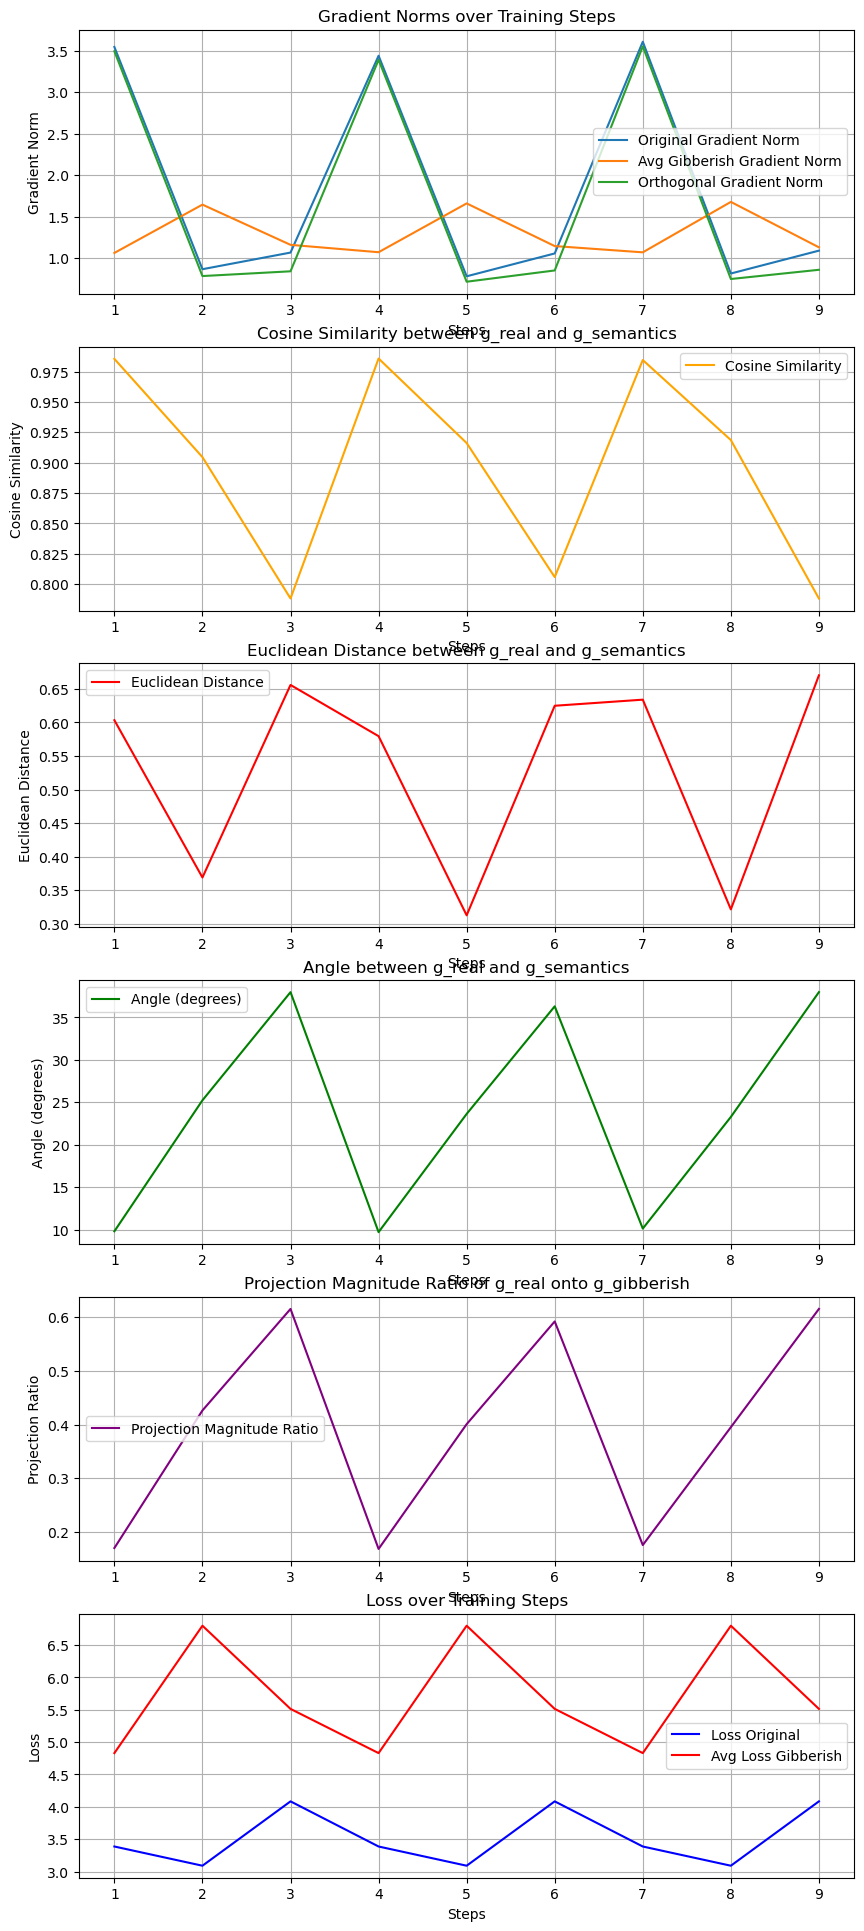

Epoch 3/3, Step 9: Loss Orig=4.0847, Avg Loss Gibb=5.5140
[3.38689923286438, 3.0898783206939697, 4.084683895111084, 3.38689923286438, 3.0898783206939697, 4.084683895111084, 3.38689923286438, 3.0898783206939697, 4.084683895111084]
[4.830666190699527, 6.799566143437436, 5.513984150356716, 4.830666190699527, 6.799566143437436, 5.513984150356716, 4.830666190699527, 6.799566143437436, 5.513984150356716]


In [51]:
# Load JSON file
json_path = "/home/tschuetz/LLM-Cognitive-Sim/data/sentence_gibberish.json"
with open(json_path, "r") as f:
    json_data = json.load(f)

# Lists to store values
norms_orig, norms_gibb, norms_ortho, steps = [], [], [], []
cos_similarities, euclidean_distances, angles, projection_ratios = [], [], [], []
losses_orig, losses_gibb = [], []  # Tracking losses

epochs = 3
batch_size = 1  # Since each original sentence has multiple gibberish variants
gradient_accumulation_steps = 9

model.train()
step_counter = 0
total_training_steps = epochs*len(list(json_data.keys()))
print(total_training_steps)

fig, axes = plt.subplots(6, 1, figsize=(10, 24))
plt.ion()

for epoch in range(epochs):
    for orig_sentence, gibberish_sentences in json_data.items():
        # Tokenize the original sentence
        orig_batch = tokenize([orig_sentence])
        orig_batch = {k: v.to(device) for k, v in orig_batch.items()}

        optimizer.zero_grad()

        # Compute original gradients
        outputs_orig = model(**orig_batch, labels=orig_batch['input_ids'])
        loss_orig = outputs_orig.loss
        loss_orig.backward()
        gradients_orig = torch.nn.utils.parameters_to_vector(
            [p.grad for p in model.parameters() if p.grad is not None])
        norm_orig = gradients_orig.norm().item()
        optimizer.zero_grad()

        # Compute gradients for all gibberish sentences and take the average
        gibberish_gradients = []
        gibberish_norms = []
        gibberish_losses = []

        for gibberish_sentence in gibberish_sentences:
            gibb_batch = tokenize([gibberish_sentence])
            gibb_batch = {k: v.to(device) for k, v in gibb_batch.items()}

            outputs_gibb = model(**gibb_batch, labels=gibb_batch['input_ids'])
            loss_gibb = outputs_gibb.loss
            loss_gibb.backward()
            gradients_gibb = torch.nn.utils.parameters_to_vector(
                [p.grad for p in model.parameters() if p.grad is not None])
            gibberish_gradients.append(gradients_gibb)
            gibberish_norms.append(gradients_gibb.norm().item())
            gibberish_losses.append(loss_gibb.item())

            optimizer.zero_grad()

        # Compute the average gibberish gradient norm
        avg_norm_gibb = sum(gibberish_norms) / len(gibberish_norms)
        avg_loss_gibb = sum(gibberish_losses) / len(gibberish_losses)

        # Orthogonal gradients via Gram-Schmidt
        with torch.no_grad():
            avg_gibberish_gradient = sum(gibberish_gradients) / len(gibberish_gradients)
            orthogonal_gradient = gram_schmidt(v_gib=avg_gibberish_gradient, v_info=gradients_orig)
            norm_ortho = orthogonal_gradient.norm().item()

            torch.nn.utils.vector_to_parameters(
                orthogonal_gradient, [p for p in model.parameters() if p.grad is not None])

        optimizer.step()

        # Compute comparison metrics
        with torch.no_grad():
            # Cosine Similarity
            cos_sim = torch.nn.functional.cosine_similarity(gradients_orig, orthogonal_gradient, dim=0).item()

            # Euclidean Distance
            euclidean_dist = torch.norm(gradients_orig - orthogonal_gradient).item()

            # Angle (in degrees)
            angle_rad = torch.acos(torch.clamp(torch.tensor(cos_sim), -1.0, 1.0)).item()
            angle_deg = torch.rad2deg(torch.tensor(angle_rad)).item()

            # Projection Magnitude Ratio
            projection = (torch.dot(gradients_orig, avg_gibberish_gradient) /
                          torch.dot(avg_gibberish_gradient, avg_gibberish_gradient)) * avg_gibberish_gradient
            projection_ratio = torch.norm(projection) / torch.norm(gradients_orig)

        # Store values
        step_counter += 1
        steps.append(step_counter)
        norms_orig.append(norm_orig)
        norms_gibb.append(avg_norm_gibb)
        norms_ortho.append(norm_ortho)
        cos_similarities.append(cos_sim)
        euclidean_distances.append(euclidean_dist)
        angles.append(angle_deg)
        projection_ratios.append(projection_ratio.item())
        losses_orig.append(loss_orig.item())   
        losses_gibb.append(avg_loss_gibb)    

        # Plot updating
        if step_counter % gradient_accumulation_steps == 0 or step_counter == total_training_steps:
            #clear_output(wait=True)

            for ax in axes:
                ax.clear()

            # Plot Gradient Norms
            axes[0].plot(steps, norms_orig, label='Original Gradient Norm')
            axes[0].plot(steps, norms_gibb, label='Avg Gibberish Gradient Norm')
            axes[0].plot(steps, norms_ortho, label='Orthogonal Gradient Norm')
            axes[0].set_xlabel('Steps')
            axes[0].set_ylabel('Gradient Norm')
            axes[0].set_title('Gradient Norms over Training Steps')
            axes[0].legend()
            axes[0].grid(True)

            # Plot Cosine Similarity
            axes[1].plot(steps, cos_similarities, label='Cosine Similarity', color='orange')
            axes[1].set_xlabel('Steps')
            axes[1].set_ylabel('Cosine Similarity')
            axes[1].set_title('Cosine Similarity between g_real and g_semantics')
            axes[1].legend()
            axes[1].grid(True)

            # Plot Euclidean Distance
            axes[2].plot(steps, euclidean_distances, label='Euclidean Distance', color='red')
            axes[2].set_xlabel('Steps')
            axes[2].set_ylabel('Euclidean Distance')
            axes[2].set_title('Euclidean Distance between g_real and g_semantics')
            axes[2].legend()
            axes[2].grid(True)

            # Plot Angle between Vectors
            axes[3].plot(steps, angles, label='Angle (degrees)', color='green')
            axes[3].set_xlabel('Steps')
            axes[3].set_ylabel('Angle (degrees)')
            axes[3].set_title('Angle between g_real and g_semantics')
            axes[3].legend()
            axes[3].grid(True)

            # Plot Projection Magnitude Ratio
            axes[4].plot(steps, projection_ratios, label='Projection Magnitude Ratio', color='purple')
            axes[4].set_xlabel('Steps')
            axes[4].set_ylabel('Projection Ratio')
            axes[4].set_title('Projection Magnitude Ratio of g_real onto g_gibberish')
            axes[4].legend()
            axes[4].grid(True)

            # Plot Losses
            axes[5].plot(steps, losses_orig, label='Loss Original', color='blue')
            axes[5].plot(steps, losses_gibb, label='Avg Loss Gibberish', color='red')
            axes[5].set_xlabel('Steps')
            axes[5].set_ylabel('Loss')
            axes[5].set_title('Loss over Training Steps')
            axes[5].legend()
            axes[5].grid(True)

            plt.draw()
            plt.pause(0.001)

            print(f"Epoch {epoch+1}/{epochs}, Step {step_counter}: "
                  f"Loss Orig={loss_orig.item():.4f}, Avg Loss Gibb={avg_loss_gibb:.4f}")

        gc.collect()
        torch.cuda.empty_cache()

plt.ioff()  # Turn off interactive mode
plt.show()  # Ensure the final figure is displayed
print(losses_orig)
print(losses_gibb)

# Save model
# model.save_pretrained("./gradient_aware_lora_finetuned_model_gaft")

In [ ]:
# Lists to store values
norms_orig, norms_gibb, norms_ortho, steps = [], [], [], []
cos_similarities, euclidean_distances, angles, projection_ratios = [], [], [], []
losses_orig, losses_gibb = [], []  # New lists for tracking losses

epochs = 3
batch_size = 1
gradient_accumulation_steps = 8

model.train()

step_counter = 0
# Updated to create 6 subplots (5 original + 1 for loss tracking)
fig, axes = plt.subplots(6, 1, figsize=(10, 24))  

for epoch in range(epochs):
    for i in range(0, len(original_texts), batch_size):
        orig_batch = tokenize(original_texts[i:i+batch_size])
        gibb_batch = tokenize(gibberish_texts[i:i+batch_size])

        # move both batches to the GPU
        orig_batch = {k: v.to(device) for k, v in tokenize(original_texts[i:i+batch_size]).items()}
        gibb_batch = {k: v.to(device) for k, v in tokenize(gibberish_texts[i:i+batch_size]).items()}


        optimizer.zero_grad()

        # Original gradients
        outputs_orig = model(**orig_batch, labels=orig_batch['input_ids'])
        loss_orig = outputs_orig.loss
        loss_orig.backward()
        gradients_orig = torch.nn.utils.parameters_to_vector(
            [p.grad for p in model.parameters() if p.grad is not None])
        norm_orig = gradients_orig.norm().item()
        optimizer.zero_grad()

        # Gibberish gradients
        outputs_gibb = model(**gibb_batch, labels=gibb_batch['input_ids'])
        loss_gibb = outputs_gibb.loss
        loss_gibb.backward()
        gradients_gibb = torch.nn.utils.parameters_to_vector(
            [p.grad for p in model.parameters() if p.grad is not None])
        norm_gibb = gradients_gibb.norm().item()
        optimizer.zero_grad()

        # Orthogonal gradients via Gram-Schmidt
        with torch.no_grad():
            orthogonal_gradient = gram_schmidt(v_gib=gradients_gibb, v_info=gradients_orig)
            norm_ortho = orthogonal_gradient.norm().item()
            torch.nn.utils.vector_to_parameters(
                orthogonal_gradient, [p for p in model.parameters() if p.grad is not None])

        optimizer.step()

        # Compute comparison metrics
        with torch.no_grad():
            # Cosine Similarity
            cos_sim = torch.nn.functional.cosine_similarity(gradients_orig, orthogonal_gradient, dim=0).item()

            # Euclidean Distance
            euclidean_dist = torch.norm(gradients_orig - orthogonal_gradient).item()

            # Angle (in degrees)
            angle_rad = torch.acos(torch.clamp(torch.tensor(cos_sim), -1.0, 1.0)).item()
            angle_deg = torch.rad2deg(torch.tensor(angle_rad)).item()

            # Projection Magnitude Ratio
            projection = (torch.dot(gradients_orig, gradients_gibb) / torch.dot(gradients_gibb, gradients_gibb)) * gradients_gibb
            projection_ratio = torch.norm(projection) / torch.norm(gradients_orig)

        # Store values including losses
        step_counter += 1
        steps.append(step_counter)
        norms_orig.append(norm_orig)
        norms_gibb.append(norm_gibb)
        norms_ortho.append(norm_ortho)
        cos_similarities.append(cos_sim)
        euclidean_distances.append(euclidean_dist)
        angles.append(angle_deg)
        projection_ratios.append(projection_ratio.item())
        losses_orig.append(loss_orig.item())   # Track original loss
        losses_gibb.append(loss_gibb.item())     # Track gibberish loss

        # Plot updating
        if step_counter % gradient_accumulation_steps == 0:
            clear_output(wait=True)

            # Clear each subplot
            for ax in axes:
                ax.clear()

            # Plot Gradient Norms
            axes[0].plot(steps, norms_orig, label='Original Gradient Norm')
            axes[0].plot(steps, norms_gibb, label='Gibberish Gradient Norm')
            axes[0].plot(steps, norms_ortho, label='Orthogonal Gradient Norm')
            axes[0].set_xlabel('Steps')
            axes[0].set_ylabel('Gradient Norm')
            axes[0].set_title('Gradient Norms over Training Steps')
            axes[0].legend()
            axes[0].grid(True)

            # Plot Cosine Similarity
            axes[1].plot(steps, cos_similarities, label='Cosine Similarity (g_real vs g_semantics)', color='orange')
            axes[1].set_xlabel('Steps')
            axes[1].set_ylabel('Cosine Similarity')
            axes[1].set_title('Cosine Similarity between g_real and g_semantics')
            axes[1].legend()
            axes[1].grid(True)

            # Plot Euclidean Distance
            axes[2].plot(steps, euclidean_distances, label='Euclidean Distance (g_real vs g_semantics)', color='red')
            axes[2].set_xlabel('Steps')
            axes[2].set_ylabel('Euclidean Distance')
            axes[2].set_title('Euclidean Distance between g_real and g_semantics')
            axes[2].legend()
            axes[2].grid(True)

            # Plot Angle between Vectors
            axes[3].plot(steps, angles, label='Angle (degrees)', color='green')
            axes[3].set_xlabel('Steps')
            axes[3].set_ylabel('Angle (degrees)')
            axes[3].set_title('Angle between g_real and g_semantics')
            axes[3].legend()
            axes[3].grid(True)

            # Plot Projection Magnitude Ratio
            axes[4].plot(steps, projection_ratios, label='Projection Magnitude Ratio', color='purple')
            axes[4].set_xlabel('Steps')
            axes[4].set_ylabel('Projection Ratio')
            axes[4].set_title('Projection Magnitude Ratio of g_real onto g_gibberish')
            axes[4].legend()
            axes[4].grid(True)

            # Plot Losses
            axes[5].plot(steps, losses_orig, label='Loss Original', color='blue')
            axes[5].plot(steps, losses_gibb, label='Loss Gibberish', color='red')
            axes[5].set_xlabel('Steps')
            axes[5].set_ylabel('Loss')
            axes[5].set_title('Loss over Training Steps')
            axes[5].legend()
            axes[5].grid(True)

            display(fig)
            plt.pause(0.001)

            print(f"Epoch {epoch+1}/{epochs}, Step {step_counter}: "
                  f"Loss Orig={loss_orig.item():.4f}, Loss Gibb={loss_gibb.item():.4f}")
            
        gc.collect()
        torch.cuda.empty_cache()


plt.show()

# Save model at the end
#model.save_pretrained("./gradient_aware_lora_finetuned_model_gaft")

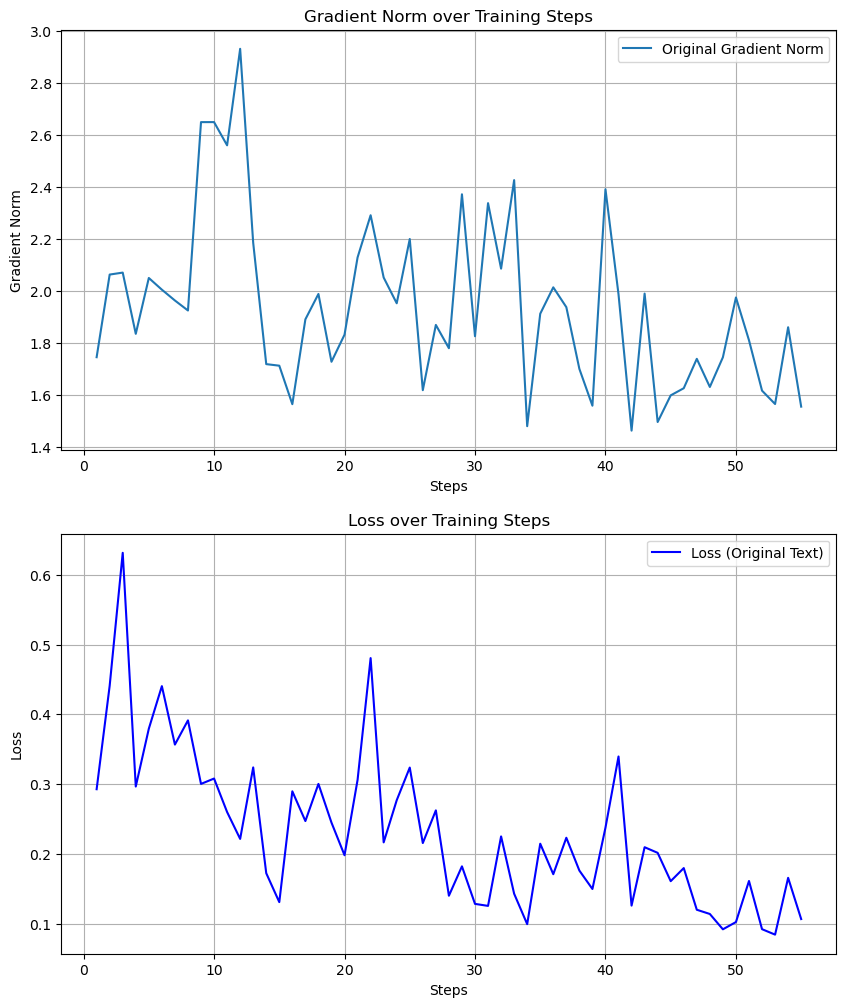

Epoch 3/3, Step 55: Loss = 0.1064


In [12]:
# Lists to store values
norms_orig, steps = [], []
losses_orig = []  # List for tracking the original loss

epochs = 3
batch_size = 3
gradient_accumulation_steps = 5

model.train()

step_counter = 0
# Create 2 subplots: one for the gradient norm and one for the loss
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

for epoch in range(epochs):
    for i in range(0, len(original_texts), batch_size):
        # Tokenize and move the original batch to the GPU
        orig_batch = {k: v.to(device) for k, v in tokenize(original_texts[i:i+batch_size]).items()}

        optimizer.zero_grad()

        # Forward pass and loss calculation using original text only
        outputs_orig = model(**orig_batch, labels=orig_batch['input_ids'])
        loss_orig = outputs_orig.loss
        loss_orig.backward()

        # Get the flattened gradient vector and compute its norm
        gradients_orig = torch.nn.utils.parameters_to_vector(
            [p.grad for p in model.parameters() if p.grad is not None])
        norm_orig = gradients_orig.norm().item()

        optimizer.step()

        # Update step counter and store metrics
        step_counter += 1
        steps.append(step_counter)
        norms_orig.append(norm_orig)
        losses_orig.append(loss_orig.item())

        # Plot updating every gradient_accumulation_steps
        if step_counter % gradient_accumulation_steps == 0:
            clear_output(wait=True)
            for ax in axes:
                ax.clear()

            # Plot Gradient Norm
            axes[0].plot(steps, norms_orig, label='Original Gradient Norm')
            axes[0].set_xlabel('Steps')
            axes[0].set_ylabel('Gradient Norm')
            axes[0].set_title('Gradient Norm over Training Steps')
            axes[0].legend()
            axes[0].grid(True)

            # Plot Loss
            axes[1].plot(steps, losses_orig, label='Loss (Original Text)', color='blue')
            axes[1].set_xlabel('Steps')
            axes[1].set_ylabel('Loss')
            axes[1].set_title('Loss over Training Steps')
            axes[1].legend()
            axes[1].grid(True)

            display(fig)
            fig.savefig(f"./lora_finetuned_model/deepseek-llm-7b-base/plain_finetuned_model_bs{batch_size}_gas{gradient_accumulation_steps}_r{r}.png")

            plt.pause(0.001)

            print(f"Epoch {epoch+1}/{epochs}, Step {step_counter}: Loss = {loss_orig.item():.4f}")

        # Optionally clear unused memory
        gc.collect()
        torch.cuda.empty_cache()

plt.show()

# Save the model at the end of fine tuning
model.save_pretrained(f"./lora_finetuned_model/deepseek-llm-7b-base/plain_finetuned_model_bs{batch_size}_gas{gradient_accumulation_steps}_r{r}")

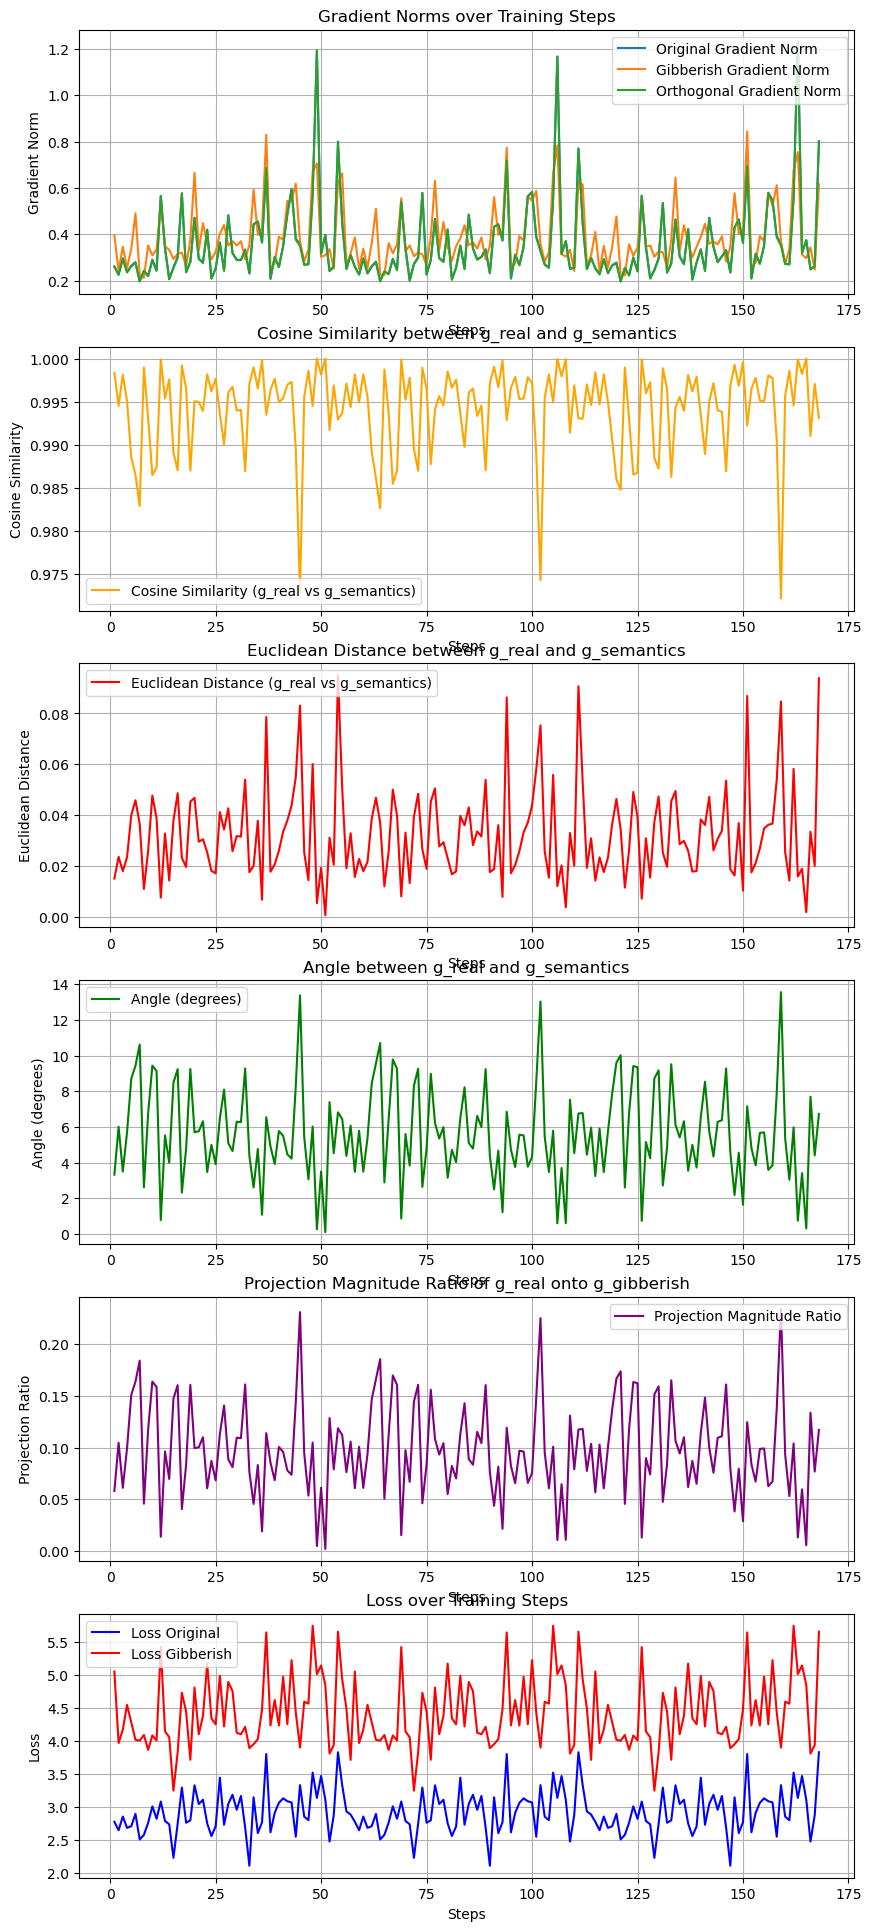

Epoch 3/3, Step 168: Loss Orig=3.8285, Loss Gibb=5.6507


In [11]:
# Lists to store values
norms_orig, norms_gibb, norms_ortho, steps = [], [], [], []
cos_similarities, euclidean_distances, angles, projection_ratios = [], [], [], []
losses_orig, losses_gibb = [], []  # New lists for tracking losses

epochs = 3
batch_size = 1
gradient_accumulation_steps = 8

model.train()

step_counter = 0
# Updated to create 6 subplots (5 original + 1 for loss tracking)
fig, axes = plt.subplots(6, 1, figsize=(10, 24))  

for epoch in range(epochs):
    for i in range(0, len(original_texts), batch_size):
        orig_batch = tokenize(original_texts[i:i+batch_size])
        gibb_batch = tokenize(gibberish_texts[i:i+batch_size])

        # move both batches to the GPU
        orig_batch = {k: v.to(device) for k, v in tokenize(original_texts[i:i+batch_size]).items()}
        gibb_batch = {k: v.to(device) for k, v in tokenize(gibberish_texts[i:i+batch_size]).items()}


        optimizer.zero_grad()

        # Original gradients
        outputs_orig = model(**orig_batch, labels=orig_batch['input_ids'])
        loss_orig = outputs_orig.loss
        loss_orig.backward()
        gradients_orig = torch.nn.utils.parameters_to_vector(
            [p.grad for p in model.parameters() if p.grad is not None])
        norm_orig = gradients_orig.norm().item()
        optimizer.zero_grad()

        # Gibberish gradients
        outputs_gibb = model(**gibb_batch, labels=gibb_batch['input_ids'])
        loss_gibb = outputs_gibb.loss
        loss_gibb.backward()
        gradients_gibb = torch.nn.utils.parameters_to_vector(
            [p.grad for p in model.parameters() if p.grad is not None])
        norm_gibb = gradients_gibb.norm().item()
        optimizer.zero_grad()

        # Orthogonal gradients via Gram-Schmidt
        with torch.no_grad():
            orthogonal_gradient = gram_schmidt(v_gib=gradients_gibb, v_info=gradients_orig)
            norm_ortho = orthogonal_gradient.norm().item()
            torch.nn.utils.vector_to_parameters(
                orthogonal_gradient, [p for p in model.parameters() if p.grad is not None])

        optimizer.step()

        # Compute comparison metrics
        with torch.no_grad():
            # Cosine Similarity
            cos_sim = torch.nn.functional.cosine_similarity(gradients_orig, orthogonal_gradient, dim=0).item()

            # Euclidean Distance
            euclidean_dist = torch.norm(gradients_orig - orthogonal_gradient).item()

            # Angle (in degrees)
            angle_rad = torch.acos(torch.clamp(torch.tensor(cos_sim), -1.0, 1.0)).item()
            angle_deg = torch.rad2deg(torch.tensor(angle_rad)).item()

            # Projection Magnitude Ratio
            projection = (torch.dot(gradients_orig, gradients_gibb) / torch.dot(gradients_gibb, gradients_gibb)) * gradients_gibb
            projection_ratio = torch.norm(projection) / torch.norm(gradients_orig)

        # Store values including losses
        step_counter += 1
        steps.append(step_counter)
        norms_orig.append(norm_orig)
        norms_gibb.append(norm_gibb)
        norms_ortho.append(norm_ortho)
        cos_similarities.append(cos_sim)
        euclidean_distances.append(euclidean_dist)
        angles.append(angle_deg)
        projection_ratios.append(projection_ratio.item())
        losses_orig.append(loss_orig.item())   # Track original loss
        losses_gibb.append(loss_gibb.item())     # Track gibberish loss

        # Plot updating
        if step_counter % gradient_accumulation_steps == 0:
            clear_output(wait=True)

            # Clear each subplot
            for ax in axes:
                ax.clear()

            # Plot Gradient Norms
            axes[0].plot(steps, norms_orig, label='Original Gradient Norm')
            axes[0].plot(steps, norms_gibb, label='Gibberish Gradient Norm')
            axes[0].plot(steps, norms_ortho, label='Orthogonal Gradient Norm')
            axes[0].set_xlabel('Steps')
            axes[0].set_ylabel('Gradient Norm')
            axes[0].set_title('Gradient Norms over Training Steps')
            axes[0].legend()
            axes[0].grid(True)

            # Plot Cosine Similarity
            axes[1].plot(steps, cos_similarities, label='Cosine Similarity (g_real vs g_semantics)', color='orange')
            axes[1].set_xlabel('Steps')
            axes[1].set_ylabel('Cosine Similarity')
            axes[1].set_title('Cosine Similarity between g_real and g_semantics')
            axes[1].legend()
            axes[1].grid(True)

            # Plot Euclidean Distance
            axes[2].plot(steps, euclidean_distances, label='Euclidean Distance (g_real vs g_semantics)', color='red')
            axes[2].set_xlabel('Steps')
            axes[2].set_ylabel('Euclidean Distance')
            axes[2].set_title('Euclidean Distance between g_real and g_semantics')
            axes[2].legend()
            axes[2].grid(True)

            # Plot Angle between Vectors
            axes[3].plot(steps, angles, label='Angle (degrees)', color='green')
            axes[3].set_xlabel('Steps')
            axes[3].set_ylabel('Angle (degrees)')
            axes[3].set_title('Angle between g_real and g_semantics')
            axes[3].legend()
            axes[3].grid(True)

            # Plot Projection Magnitude Ratio
            axes[4].plot(steps, projection_ratios, label='Projection Magnitude Ratio', color='purple')
            axes[4].set_xlabel('Steps')
            axes[4].set_ylabel('Projection Ratio')
            axes[4].set_title('Projection Magnitude Ratio of g_real onto g_gibberish')
            axes[4].legend()
            axes[4].grid(True)

            # Plot Losses
            axes[5].plot(steps, losses_orig, label='Loss Original', color='blue')
            axes[5].plot(steps, losses_gibb, label='Loss Gibberish', color='red')
            axes[5].set_xlabel('Steps')
            axes[5].set_ylabel('Loss')
            axes[5].set_title('Loss over Training Steps')
            axes[5].legend()
            axes[5].grid(True)

            display(fig)
            plt.pause(0.001)

            print(f"Epoch {epoch+1}/{epochs}, Step {step_counter}: "
                  f"Loss Orig={loss_orig.item():.4f}, Loss Gibb={loss_gibb.item():.4f}")
            
        gc.collect()
        torch.cuda.empty_cache()


plt.show()

# Save model at the end
model.save_pretrained("./gradient_aware_lora_finetuned_model_gaft")

RuntimeError: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/opt/conda/conda-bld/pytorch_1729647382455/work/c10/cuda/CUDACachingAllocator.cpp":995, please report a bug to PyTorch. 

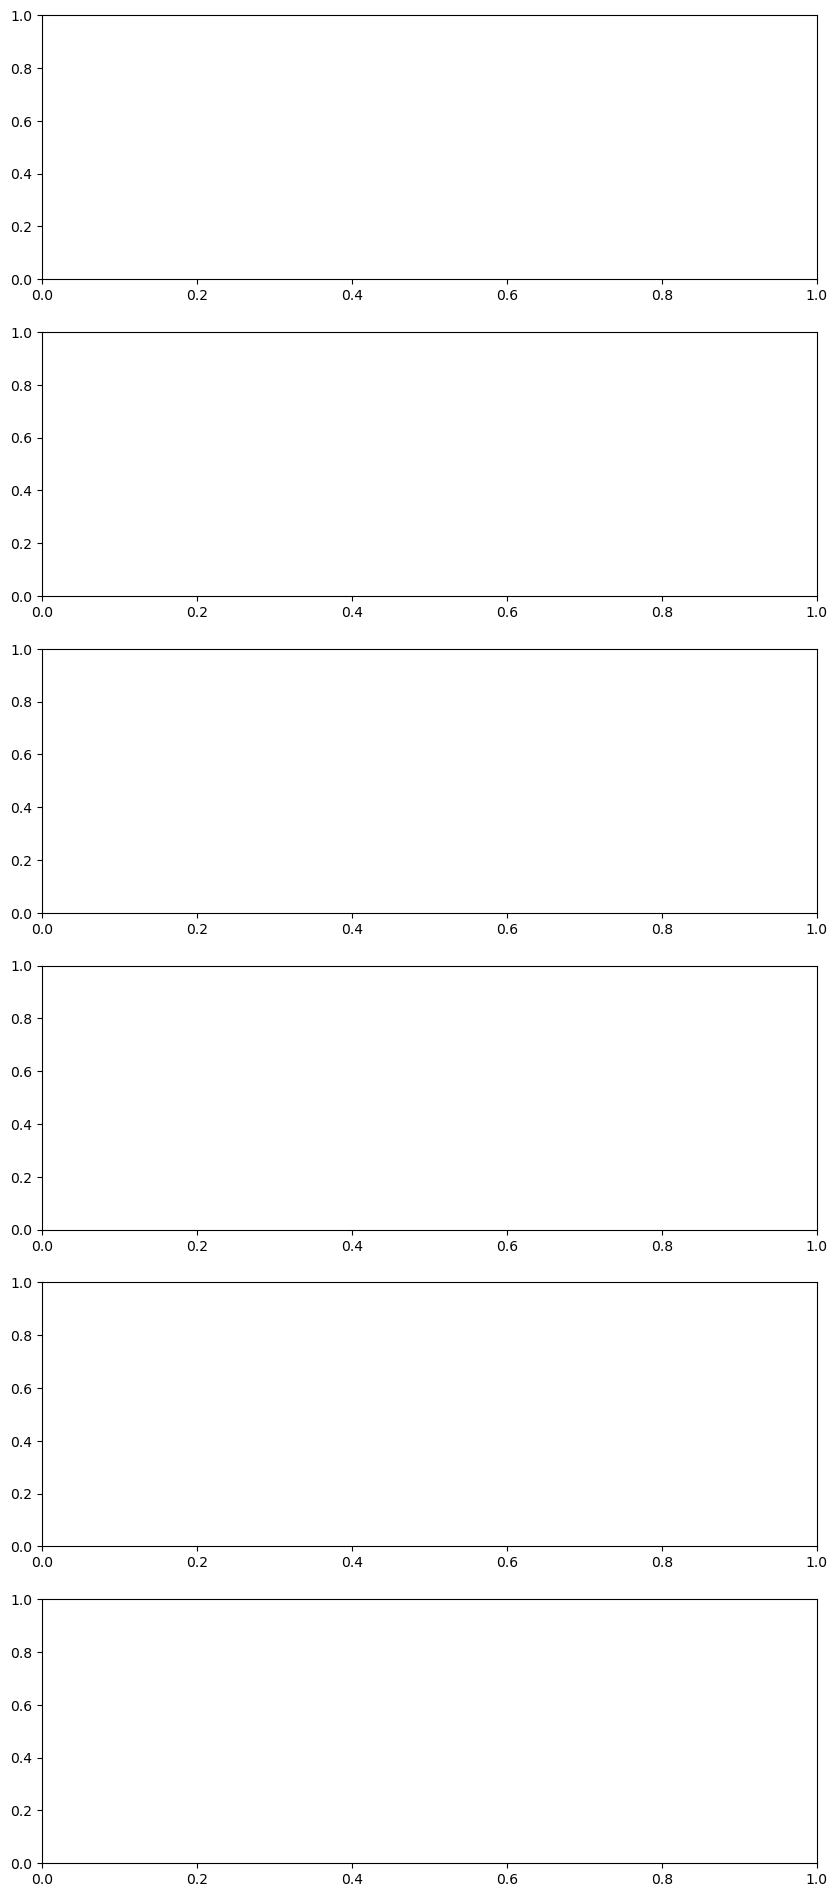

In [8]:
# !!!! not working, bc gradient vector gets mixed up when moving it to the CPU
# Lists to store values
norms_orig, norms_gibb, norms_ortho, steps = [], [], [], [] # lists for tracking norms and steps
cos_similarities, euclidean_distances, angles, projection_ratios = [], [], [], [] # lists for tracking metrics
losses_orig, losses_gibb = [], []  # lists for tracking losses

epochs = 3
batch_size = 1
gradient_accumulation_steps = 8

model.train()

step_counter = 0
# Updated to create 6 subplots (5 original + 1 for loss tracking)
fig, axes = plt.subplots(6, 1, figsize=(10, 24))  

for epoch in range(epochs):
    for i in range(0, len(original_texts), batch_size):
        # Process original batch first
        orig_batch = {k: v.to(device) for k, v in tokenize(original_texts[i:i+batch_size]).items()}
        optimizer.zero_grad()
        outputs_orig = model(**orig_batch, labels=orig_batch['input_ids'])
        loss_orig = outputs_orig.loss
        losses_orig.append(loss_orig.item())   # Track original loss
        loss_orig.backward()
        # Detach and move gradients to CPU to free GPU memory (if size permits)
        """ gradients_orig = torch.nn.utils.parameters_to_vector(
            [p.grad for p in model.parameters() if p.grad is not None]).detach().cpu() """
        gradients_orig = all_gradients_to_vector(model.parameters()).detach().cpu()
        norm_orig = gradients_orig.norm().item()
        # Clean up the original batch and related tensors
        del orig_batch, outputs_orig, loss_orig
        torch.cuda.empty_cache()
        
        # Process gibberish batch
        gibb_batch = {k: v.to(device) for k, v in tokenize(gibberish_texts[i:i+batch_size]).items()}
        optimizer.zero_grad()
        outputs_gibb = model(**gibb_batch, labels=gibb_batch['input_ids'])
        loss_gibb = outputs_gibb.loss
        losses_gibb.append(loss_gibb.item())     # Track gibberish loss
        loss_gibb.backward()
        """ gradients_gibb = torch.nn.utils.parameters_to_vector(
            [p.grad for p in model.parameters() if p.grad is not None]) """
        gradients_gibb = all_gradients_to_vector(model.parameters())
        norm_gibb = gradients_gibb.norm().item()
        del gibb_batch, outputs_gibb, loss_gibb
        torch.cuda.empty_cache()
        
        # Move the original gradient back to GPU for combining, if needed
        gradients_orig = gradients_orig.to(device)
        # Combine gradients using Gram–Schmidt (or another method)
        with torch.no_grad():
            orthogonal_gradient = gram_schmidt(v_gib=gradients_gibb, v_info=gradients_orig)
            norm_ortho = orthogonal_gradient.norm().item()
            torch.nn.utils.vector_to_parameters(
                orthogonal_gradient, [p for p in model.parameters() if p.grad is not None])
        
        optimizer.step()

        # Compute comparison metrics
        with torch.no_grad():
            # Cosine Similarity
            cos_sim = torch.nn.functional.cosine_similarity(gradients_orig, orthogonal_gradient, dim=0).item()

            # Euclidean Distance
            euclidean_dist = torch.norm(gradients_orig - orthogonal_gradient).item()

            # Angle (in degrees)
            angle_rad = torch.acos(torch.clamp(torch.tensor(cos_sim), -1.0, 1.0)).item()
            angle_deg = torch.rad2deg(torch.tensor(angle_rad)).item()

            # Projection Magnitude Ratio
            projection = (torch.dot(gradients_orig, gradients_gibb) / torch.dot(gradients_gibb, gradients_gibb)) * gradients_gibb
            projection_ratio = torch.norm(projection) / torch.norm(gradients_orig)

        # Store values including losses
        step_counter += 1
        steps.append(step_counter)
        norms_orig.append(norm_orig)
        norms_gibb.append(norm_gibb)
        norms_ortho.append(norm_ortho)
        cos_similarities.append(cos_sim)
        euclidean_distances.append(euclidean_dist)
        angles.append(angle_deg)
        projection_ratios.append(projection_ratio.item())
        #losses_orig.append(loss_orig.item())   # Track original loss
        #losses_gibb.append(loss_gibb.item())     # Track gibberish loss

        # Plot updating
        if step_counter % gradient_accumulation_steps == 0:
            clear_output(wait=True)

            # Clear each subplot
            for ax in axes:
                ax.clear()

            # Plot Gradient Norms
            axes[0].plot(steps, norms_orig, label='Original Gradient Norm')
            axes[0].plot(steps, norms_gibb, label='Gibberish Gradient Norm')
            axes[0].plot(steps, norms_ortho, label='Orthogonal Gradient Norm')
            axes[0].set_xlabel('Steps')
            axes[0].set_ylabel('Gradient Norm')
            axes[0].set_title('Gradient Norms over Training Steps')
            axes[0].legend()
            axes[0].grid(True)

            # Plot Cosine Similarity
            axes[1].plot(steps, cos_similarities, label='Cosine Similarity (g_real vs g_semantics)', color='orange')
            axes[1].set_xlabel('Steps')
            axes[1].set_ylabel('Cosine Similarity')
            axes[1].set_title('Cosine Similarity between g_real and g_semantics')
            axes[1].legend()
            axes[1].grid(True)

            # Plot Euclidean Distance
            axes[2].plot(steps, euclidean_distances, label='Euclidean Distance (g_real vs g_semantics)', color='red')
            axes[2].set_xlabel('Steps')
            axes[2].set_ylabel('Euclidean Distance')
            axes[2].set_title('Euclidean Distance between g_real and g_semantics')
            axes[2].legend()
            axes[2].grid(True)

            # Plot Angle between Vectors
            axes[3].plot(steps, angles, label='Angle (degrees)', color='green')
            axes[3].set_xlabel('Steps')
            axes[3].set_ylabel('Angle (degrees)')
            axes[3].set_title('Angle between g_real and g_semantics')
            axes[3].legend()
            axes[3].grid(True)

            # Plot Projection Magnitude Ratio
            axes[4].plot(steps, projection_ratios, label='Projection Magnitude Ratio', color='purple')
            axes[4].set_xlabel('Steps')
            axes[4].set_ylabel('Projection Ratio')
            axes[4].set_title('Projection Magnitude Ratio of g_real onto g_gibberish')
            axes[4].legend()
            axes[4].grid(True)

            # Plot Losses
            axes[5].plot(steps, losses_orig, label='Loss Original', color='blue')
            axes[5].plot(steps, losses_gibb, label='Loss Gibberish', color='red')
            axes[5].set_xlabel('Steps')
            axes[5].set_ylabel('Loss')
            axes[5].set_title('Loss over Training Steps')
            axes[5].legend()
            axes[5].grid(True)

            display(fig)
            plt.pause(0.001)

            print(f"Epoch {epoch+1}/{epochs}, Step {step_counter}: "
                  f"Loss Orig={losses_orig[-1]:.4f}, Loss Gibb={losses_gibb[-1]:.4f}")
            
        gc.collect()
        torch.cuda.empty_cache()


plt.show()

# Save model at the end
model.save_pretrained("./gradient_aware_lora_finetuned_model_gaft")